# Planet Terror

Jack Carter - 26/08/2022

## Summary

This project uses a refined version of the terorrism risk headlines obtained in the author's 'Risky Business' project to determine whether neural networks can perform well on small data sets. Despite only having 128 terror event headlines to work with, the RNN model achieves an accuracy of over 90%. 

## 1) Preparation

### Import libraries & set options

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

### Read in the terror events data frame

The terror events data frame contains roughly 120 terror event headlines combined with about 180 falseflag and around 150 other violence risk headlines. 
Falseflag headlines contain terrorism related words but do not constitute a terror event, while the other violence risk headlines include military conflict, social unrest and organized crime related news. 

In [2]:
# creates a risks data set with terrorism and non-terrorism headlines. 
terror_events = pd.read_csv('C:/Users/HUAWEI/Desktop/Exploratory data/Planet Terror/Data/terror_events.csv', encoding = 'ISO-8859-1')

# view sample headlines:
terror_events.head(4)

,Headline,Category
0,"Al-Shabab terrorist attack at Somali hotel kills 20, injures 40",terrorism
1,Several killed in suspected ISIL attack on northeast Syria iftar,terrorism
2,Five Dead in Attack by Suspected FARC Dissidents in Colombia,terrorism
3,Terrorist attacks in Mali leave 66 dead,terrorism


### Read in the random data frame

The random data frame contains a variety of headlines from online papers across the world which did not score anything in terms of violence risks on the author's previous 'Risky Business' project. 

In [3]:
# creates a random data set. 
# these random headlines give the algorithm a clear idea of what isn't terrorism. 
random_data = pd.read_csv('C:/Users/HUAWEI/Desktop/Exploratory data/Planet Terror/Data/random_headlines.csv', encoding = 'ISO-8859-1')
random_df = random_data.sample(100)

### Combine the data

In [4]:
# creates a combined data frame, drops duplicates and checks how many of each headlines type.
combined_data = pd.concat([terror_events, random_df.iloc[:,0:2]])
unique = combined_data.loc[:,'Headline'].drop_duplicates().index
df = combined_data.iloc[unique,:]
df.Category.value_counts()

falseflag            209
terrorism            155
military_conflict     91
social_unrest         81
organized_crime       79
random                 2
Name: Category, dtype: int64

### Re-assign labels

In [5]:
# checks how many terrorism vs non-terrorism headlines we have.
target = 'terrorism'
combined_data.loc[combined_data['Category'] != target, 'Category'] = 'none'
combined_data.Category.value_counts()

none         495
terrorism    128
Name: Category, dtype: int64

In [6]:
# checks the percentage of terrorism vs non-terrorism headlines. 
non_terror = len(combined_data.loc[combined_data['Category'] != target, 'Category'])
terror = len(combined_data.loc[combined_data['Category'] == target, 'Category'])

print('The ratio of terror headlines is: ' + str(round(terror/non_terror, 2)*100) + '%')

The ratio of terror headlines is: 26.0%


### Split into training and test sets

In [7]:
# splits the data into train and test sets and prints the percentage of headlines in each data set. 
x = combined_data['Headline']
y = np.where(combined_data['Category'] == target, 1, 0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2007)

for dataset in [x_train, x_test]:
    print('Dataset has {}{} of the data.'.format((round(len(dataset) / len(combined_data['Headline']), 2))*100, '%'))

Dataset has 80.0% of the data.
Dataset has 20.0% of the data.


### Convert headlines to sequences

The headlines are converted to sequences where each unique word has its own number.

In [8]:
# 'fit_on_texts' assigns a unique number for each word in our vocab.
# 'texts_to_sequences' replaces each headline with a number sequence. 
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# views a sample sequence:
x_train_seq[0]

[39, 362, 632, 29, 633, 634, 2, 109, 243]

### Pad sequences

The sequences are then padded with extra zeros at the beginning to ensure the same length for the machine learning process. If any headlines are longer than the limit of 30 set here, only the last 30 words are used.

In [9]:
# 'pad_sequences' adds zeros to begining of all sequences untill each is equal to our max length (50).
# this is needed to ensure we have matrices of the same length later on in the process. 
x_train_seq_padded = pad_sequences(x_train_seq, 30)
x_test_seq_padded = pad_sequences(x_test_seq, 30)

# view a sample padded sequence:
x_train_seq_padded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  39, 362, 632,  29, 633,
       634,   2, 109, 243])

## 2) Training

### Import libraries and define functions

Two functions are defined to give us the recall and precision evaluation metrics. Another two are defined to compile and fit our test models, including the feed-forward, convolutional and recurrent neural network models.

In [10]:
# imports functions and defines two functions to test recall and precision.  
import keras.backend as K
from keras import layers
from keras.layers import Dense, Embedding, Conv1D, LSTM
from keras.models import Sequential

epochs = 15

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision

def m_compile(model):
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision, recall])
    
def m_fit(model):
    history = model.fit(x_train_seq_padded, y_train, 
                    batch_size=32, epochs=epochs,
                    validation_data=(x_test_seq_padded, y_test))
    return history

### The feed-forward model (fnn)

The feed-forward model is the first and most simple type of neural network model. It works by feeding inputs forward from one node to another while attemping to maximise accuracy and minimize error.

In [11]:
# builds a simple fnn model with several layers. 
fnn = Sequential()
fnn.add(Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=32))
fnn.add(layers.GlobalMaxPooling1D())
fnn.add(Dense(32, activation='relu'))
fnn.add(Dense(1, activation='sigmoid'))
fnn.summary()

# compiles the model. 
m_compile(fnn)

# fits the model. 
fnn_history = m_fit(fnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          61824     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 62,913
Trainable params: 62,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
16/16 [==============================] - 1s 15ms/step - loss: 0.6755 - accuracy: 0.7149 - precision: 0.0785

### The convolutional model (cnn)

The convolutional model is a type of feed-forward neural network which extracts features from filters, creates feature maps and then pools the output (downsamples the feature map's dimensionality) to better generalize the results. 

In [12]:
# builds a simple cnn model with several layers. 
cnn = Sequential()
cnn.add(layers.Embedding(len(tokenizer.index_word)+1, 50, input_length=30))
cnn.add(layers.Conv1D(32, 8, activation='relu'))
cnn.add(layers.GlobalMaxPooling1D())
cnn.add(layers.Dense(10, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

# compiles the model. 
m_compile(cnn)

# fits the model. 
cnn_history = m_fit(cnn)

Epoch 1/15
16/16 [==============================] - 1s 15ms/step - loss: 0.6274 - accuracy: 0.7771 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5019 - val_accuracy: 0.8640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
16/16 [==============================] - 0s 5ms/step - loss: 0.5310 - accuracy: 0.7771 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4023 - val_accuracy: 0.8640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
16/16 [==============================] - 0s 4ms/step - loss: 0.5071 - accuracy: 0.7771 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4073 - val_accuracy: 0.8640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
16/16 [==============================] - 0s 4ms/step - loss: 0.4719 - accuracy: 0.7771 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3875 - val_accuracy: 0.8640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
16/16 [=============================

### The recurrent model (rnn)

The recurrent model is a type of neural network which remembers and takes into account previous inputs when passing information through the network. This makes it more effective at understanding sequences and therefore the context of sentences.

In [13]:
# builds a simple rnn model with several layers. 
rnn = Sequential()
rnn.add(Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=32))
rnn.add(LSTM(32, dropout=0.25, recurrent_dropout=0.25))
rnn.add(Dense(32, activation='relu'))
rnn.add(Dense(1, activation='sigmoid'))

# compiles the model. 
m_compile(rnn)

# fits the model. 
rnn_history = m_fit(rnn)

Epoch 1/15
16/16 [==============================] - 3s 33ms/step - loss: 0.6654 - accuracy: 0.7490 - precision: 0.0354 - recall: 0.0393 - val_loss: 0.5705 - val_accuracy: 0.8640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
16/16 [==============================] - 0s 13ms/step - loss: 0.5321 - accuracy: 0.7771 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3815 - val_accuracy: 0.8640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
16/16 [==============================] - 0s 13ms/step - loss: 0.4951 - accuracy: 0.7771 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4044 - val_accuracy: 0.8640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
16/16 [==============================] - 0s 13ms/step - loss: 0.4472 - accuracy: 0.7771 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3223 - val_accuracy: 0.8640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
16/16 [==============================] - 

## 3) Evaluation

### Summary table

The summary table shows how the rnn model outperforms the others when it comes to accuracy, precision and recall on the validation data.

In [14]:
# prints the average of the last 4 epochs.
import matplotlib.pyplot as plt

def model_summary(model):
    metrics = []
    history = model + '_history.history'
    for i in ['accuracy', 'precision', 'recall']:
        metrics.append(round(sum(eval(history)['val_{}'.format(i)][(epochs-4):epochs])/4,2))
    df = pd.DataFrame() 
    df[model] = metrics
    df.index = ['accuracy', 'precision', 'recall']
    return df

models = ['fnn', 'cnn', 'rnn']
results = pd.DataFrame()

for model in models:
    results[model] = model_summary(model)
    
results

,fnn,cnn,rnn
accuracy,0.93,0.92,0.92
precision,0.66,0.69,0.76
recall,0.63,0.67,0.66


### Validation results by epoch

The results by epoch show how the best results on the validation data are generally obtained by around the tenth epoch.

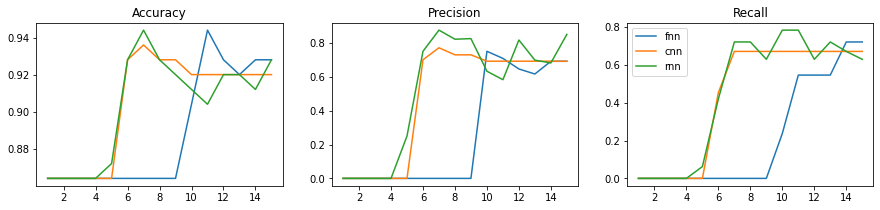

In [15]:
# plots the results for each algorithm on the validation data by epoch. 
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall']

fnn_data = pd.DataFrame()
cnn_data = pd.DataFrame()
rnn_data = pd.DataFrame()

for metric in metrics:
    fnn_data[metric] = fnn_history.history['val_{}'.format(metric)]
    cnn_data[metric] = cnn_history.history['val_{}'.format(metric)]
    rnn_data[metric] = rnn_history.history['val_{}'.format(metric)]
    epochs = range(1, len(fnn_data) + 1)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
for i in range(len(metrics)):
    axes[i].set_title(metrics[i].title())
    axes[i].plot(epochs, fnn_data[metrics[i]], label='fnn')
    axes[i].plot(epochs, cnn_data[metrics[i]], label='cnn')
    axes[i].plot(epochs, rnn_data[metrics[i]], label='rnn')
plt.legend()
plt.show()

### Training vs validation results

In [16]:
# defines a fucnction which plots training verses validation data to see if we are over or underfitting. 
def get_train_val(model):
    acc = pd.DataFrame()
    
    for i in metrics:
        acc[i] = eval(model + '_history.history')[i]
        acc['val_'+i] = eval(model + '_history.history')['val_{}'.format(i)]
        
    acc['epoch'] = range(1, len(acc) + 1)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
    for i in range(len(metrics)):
        axes[i].set_title(metrics[i].title())
        axes[i].plot(acc['epoch'], acc[metrics[i]], 'b', label='Training')
        axes[i].plot(acc['epoch'], acc['val_' + metrics[i]], 'r', label='Validation')
    plt.legend()
    plot = plt.show()

### 1. fnn...

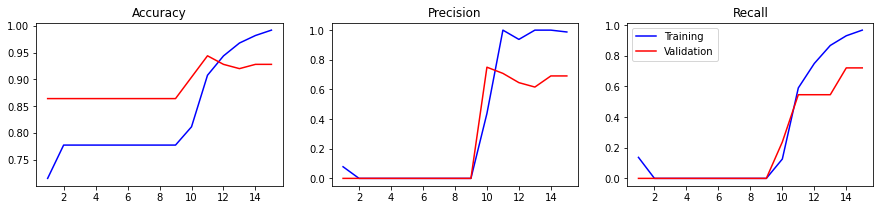

In [17]:
get_train_val('fnn')

### 2. cnn...

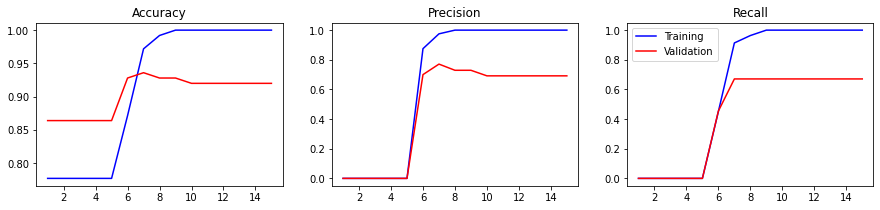

In [18]:
get_train_val('cnn')

### 3. rnn...

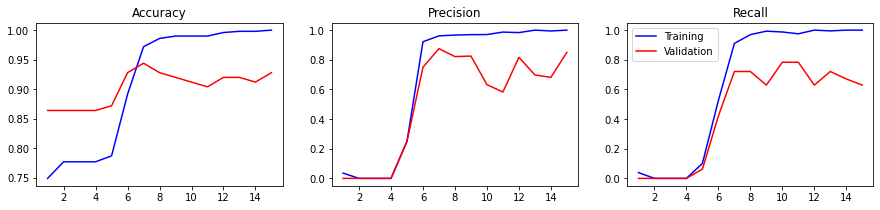

In [19]:
get_train_val('rnn')

In [20]:
# locates and saves to csv the wrongly predicted headlines for each model. 
models = ['fnn', 'cnn', 'rnn']

for model in models:
    prediction = np.round(eval(model).predict(x_test_seq_padded))
    unlisted_preds = [item for sublist in prediction for item in sublist]
    
    wrong_predictions = unlisted_preds != y_test
    false_predictions = x_test[wrong_predictions]
    
    mis_labeled = combined_data.loc[false_predictions.index,]
    
    mis_labeled.to_csv('C:/Users/HUAWEI/Desktop/Exploratory data/Planet Terror/Data/mis-labeled/{}_mislabeled.csv'.format(model))
    
    print('{}: '.format(model) + str(len(mis_labeled)) + ' mislabelled headlines - ' + str(round(len(mis_labeled)/len(y_test)*100,2)) + '% of the data.')

4/4 [==============================] - 0s 1ms/step
fnn: 10 mislabelled headlines - 8.0% of the data.
4/4 [==============================] - 0s 2ms/step
cnn: 11 mislabelled headlines - 8.8% of the data.
4/4 [==============================] - 0s 3ms/step
rnn: 10 mislabelled headlines - 8.0% of the data.


In [21]:
# views the headlines that are mislabelled by at least two of our models.
mislabeled_headlines = []

for model in models:
    mislabeled_headlines.append(pd.read_csv('C:/Users/HUAWEI/Desktop/Exploratory data/Planet Terror/Data/mis-labeled/{}_mislabeled.csv'.format(model)))
    
x = mislabeled_headlines[0].iloc[:,1]
y = mislabeled_headlines[1].iloc[:,1]
z = mislabeled_headlines[2].iloc[:,1]

problem_headlines = []
for i in x: problem_headlines.append(i in list(y) or i in list(z))

df = mislabeled_headlines[0][problem_headlines].iloc[:,1:3]
df

,Headline,Category
0,Terrorist attack in Belgorod prevented; No evacuation from Azovstal iron works,none
1,Terrorist group kills 2 members of Internal Security Forces in Daraa,terrorism
4,2 PMU forces martyred in ISIL attack on Iraq's Samarra,terrorism
5,"Islamic State claims Nigeria bombing, says about 30 killed or hurt",terrorism
6,"12 YPG/PKK terrorists killed in northern Syria, Iraq",none
7,YPG/PKK suicide attack in Syria's Afrin foiled,none
9,PKK exploits out-of-school activities to recruit children,terrorism
